In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from cvnn import layers 

2023-08-30 09:35:39.859284: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 09:35:40.840246: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# data_loc = '/home/saumya/Documents/NRSC internship/Dataset/MRSDP_SLC_DATA/EOS4_FRS1_SLC/Pauli_Lee5X5/'
# file_loc = '/home/saumya/Documents/NRSC internship/Dataset/MRSDP_SLC_DATA/EOS4_FRS1_SLC/scene_HH/'

In [3]:
file_loc = '/home/saumya/Documents/NRSC SAR CVNN/Data-sets/MRSDP_SLC_DATA/EOS4_FRS1_SLC/scene_HH/'
data_loc = '/home/saumya/Documents/NRSC SAR CVNN/Data-sets/MRSDP_SLC_DATA/EOS4_FRS1_SLC/Pauli_Lee5X5/'

In [4]:
mask = np.load(data_loc+'mask.npy')

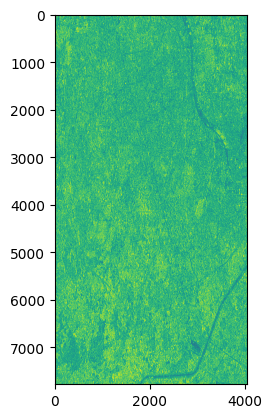

In [5]:
plt.imshow(mask)

In [6]:
input = np.load(file_loc+'input.npy')

In [7]:
import patchify as pat

In [8]:
patches_inp = pat.patchify(input, (256, 256), step=256)
patches_mask = pat.patchify(mask, (256, 256), step=256)

In [9]:
input_img = np.reshape(patches_inp, [450, 256, 256])
mask_img = np.reshape(patches_mask, [450, 256, 256])

In [10]:
input_img = np.expand_dims(input_img, -1)
mask_img = np.expand_dims(mask_img, -1)

In [11]:
from keras.utils import to_categorical
classes = np.unique(mask_img[0]).astype(int)
mask_cat = to_categorical(mask_img)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_img, mask_cat, test_size = 0.25, random_state = 4)

In [13]:
mask_cat[0].shape

(256, 256, 4)

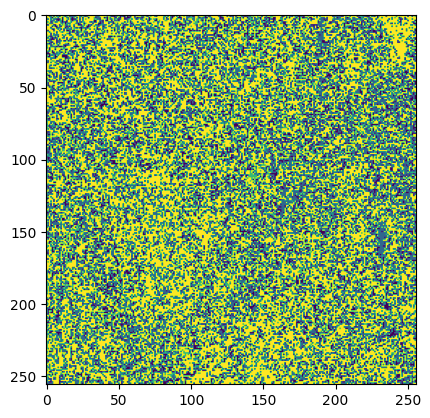

In [14]:
plt.imshow(mask_img[25])

In [15]:
X_train.shape[1:]

(256, 256, 1)

In [16]:
input_shape = (X_train.shape[1:])
# input_shape = np.array(input_shape).reshape(-1, 256, 256, 1)
dtype  = tf.complex64

In [17]:
def _downsample_cvnn(inputs, units, dtype=dtype):
    c1 = layers.ComplexConv2D(units, kernel_size=3, activation='cart_relu', kernel_initializer='ComplexHeNormal', padding='same', dtype = dtype)(inputs)
    c1 = layers.ComplexDropout(0.3)(c1)
    # c1 = layers.ComplexBatchNormalization(dtype=dtype)
    c1 = layers.ComplexConv2D(units, kernel_size=3, activation='cart_relu', kernel_initializer='ComplexHeNormal', padding='same', dtype= dtype)(c1)
    p1 = layers.ComplexMaxPooling2D((2,2), dtype=dtype)(c1)
    return (c1, p1)

In [18]:
# def _downsample_cvnn(inputs, units):
#     c0 = layers.ComplexConv2D(units, activation='cart_relu', kernel_size=3)(inputs)
#     c1 = layers.ComplexConv2D(units, activation='cart_relu', kernel_size=3)(c0)
#     c2 = layers.ComplexMaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c1)
#     return c0, c1, c2

In [19]:
def _upsample_cvnn(in1, in2, units, dtype = dtype):
    # print(in1.shape)
    t01 = layers.ComplexConv2DTranspose(units, (2, 2), strides=(2,2), activation='cart_relu', dtype=dtype, padding='same')(in1)
    t01 = layers.ComplexDropout(0.3)(t01)
    # crop01 = tf.keras.layers.Cropping2D(cropping=(crop, crop))(in2)
    # t01 = layers.ComplexUpSampling2D(size=4, interpolation='bilinear', data_format='channels_first')(t01)
    # print(t01.shape)
    concat01 = tf.keras.layers.concatenate([t01, in2], axis=-1)

    out1 = layers.ComplexConv2D(units, activation='cart_relu', kernel_size=3, dtype=dtype, padding='same')(concat01)
    out2 = layers.ComplexConv2D(units, activation='cart_relu', kernel_size=3, dtype=dtype, padding ='same')(out1)
    return out1, out2

In [20]:
input_shape

(256, 256, 1)

In [21]:
from cvnn.losses import ComplexAverageCrossEntropy

In [22]:
def cvnn_unet(dtype = tf.complex64):
    tf.random.set_seed(1)
    inputs = layers.complex_input(shape=input_shape, dtype=dtype)
    # c91, c92, c93 = _downsample_cvnn(inputs, 32, dtype)
    c0, c1 = _downsample_cvnn(inputs, 64)
    c3, c4 = _downsample_cvnn(c1, 128)
    c6, c7 = _downsample_cvnn(c4, 256)
    c9, c10 = _downsample_cvnn(c7, 512)
    # print(c9.shape)
    # print(c10.shape)

    # c12 = layers.ComplexConv2D(1024, activation='cart_relu', kernel_size=3)(c10)
    # c13 = layers.ComplexConv2D(1024, activation='cart_relu', kernel_size=3, padding='valid')(c12)

    c14, c15 = _upsample_cvnn(c10, c9, 512, dtype)
    c16, c17 = _upsample_cvnn(c15, c6, 256, dtype)
    c18, c19 = _upsample_cvnn(c17, c3, 128, dtype)
    c20, c21 = _upsample_cvnn(c19, c0, 64, dtype)

    outputs = layers.ComplexConv2D(4, kernel_size=1)(c21)
    # outputs = layers.ComplexConv2D(1, kernel_size=1)(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="u-net-cvnn")
    model.compile(loss=ComplexAverageCrossEntropy(), optimizer="adam", metrics=["accuracy"])
    return model


In [23]:
k = cvnn_unet()
print(k.summary())

2023-08-30 09:35:46.430890: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-30 09:35:46.489801: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-30 09:35:46.490134: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "u-net-cvnn"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (ComplexInput)      [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 complex_conv2d (ComplexCon  (None, 256, 256, 64)         1280      ['input_1[0][0]']             
 v2D)                                                                                             
                                                                                                  
 complex_dropout (ComplexDr  (None, 256, 256, 64)         0         ['complex_conv2d[0][0]']      
 opout)                                                                                           
                                                                                         

In [24]:
# model = tf.keras.models.Sequential()
# model.add(complex_layers.ComplexInput(input_shape=input_shape + (3,)))
# model.add(complex_layers.ComplexConv2D(32, (2, 2), activation='cart_leaky_relu', padding='same'))
# model.add(complex_layers.ComplexMaxPooling2D((2, 2)))
# model.add(complex_layers.ComplexConv2D(64, (2, 2), activation='cart_leaky_relu', padding='same'))
# model.add(complex_layers.ComplexMaxPooling2D((2, 2)))
# model.add(complex_layers.ComplexConv2D(128, (2, 2), activation='cart_leaky_relu', padding='same'))
# model.add(complex_layers.ComplexMaxPooling2D((2, 2)))
# model.add(complex_layers.ComplexConv2D(256, (2, 2), activation='cart_leaky_relu', padding='same'))
# model.add(complex_layers.ComplexMaxPooling2D((2, 2)))
# model.add(complex_layers.ComplexFlatten())

In [25]:
history = k.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

2023-08-30 09:35:50.671014: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 353370112 exceeds 10% of free system memory.
2023-08-30 09:35:51.106554: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 353370112 exceeds 10% of free system memory.


Epoch 1/10


2023-08-30 09:35:58.951967: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-30 09:35:59.285731: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-30 09:36:09.313243: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 512.00MiB (rounded to 536870912)requested by op u-net-cvnn/complex_conv2d/ComplexConv2D_3
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-08-30 09:36:09.313308: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-08-30 09:36:09.313329: I tensorf

ResourceExhaustedError: Graph execution error:

Detected at node 'u-net-cvnn/complex_conv2d/ComplexConv2D_3' defined at (most recent call last):
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 728, in start
      self.io_loop.start()
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_67767/1388493979.py", line 1, in <module>
      history = k.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/engine/training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/cvnn/layers/convolutional.py", line 284, in call
      imag_outputs = self.convolution_op(inputs_r, kernel_i) + self.convolution_op(inputs_i, kernel_r)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/cvnn/layers/convolutional.py", line 251, in convolution_op
      name=self.__class__.__name__)
Node: 'u-net-cvnn/complex_conv2d/ComplexConv2D_3'
Detected at node 'u-net-cvnn/complex_conv2d/ComplexConv2D_3' defined at (most recent call last):
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 728, in start
      self.io_loop.start()
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_67767/1388493979.py", line 1, in <module>
      history = k.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/engine/training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/cvnn/layers/convolutional.py", line 284, in call
      imag_outputs = self.convolution_op(inputs_r, kernel_i) + self.convolution_op(inputs_i, kernel_r)
    File "/home/saumya/.conda/envs/tf2/lib/python3.9/site-packages/cvnn/layers/convolutional.py", line 251, in convolution_op
      name=self.__class__.__name__)
Node: 'u-net-cvnn/complex_conv2d/ComplexConv2D_3'
2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[32,64,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node u-net-cvnn/complex_conv2d/ComplexConv2D_3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[AddN_46-0-0-TransposeNCHWToNHWC-LayoutOptimizer/_212]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[32,64,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node u-net-cvnn/complex_conv2d/ComplexConv2D_3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_13227]

In [ ]:
X_train.shape

(337, 256, 256, 1)

In [ ]:
y_train.shape

(337, 256, 256)